In [250]:
from __future__ import print_function
import random
import yfinance as yf
from os import walk
import requests
import pandas as pd
import numpy as np
import datetime
import argparse
import multiprocessing as mp
import datetime as dt


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn import preprocessing

In [251]:

def load_data(input_data_path, filenames):
    # merge datasets available on the output folder
    dfs = []
    for file in filenames:
        dfs.append(pd.read_json(input_data_path + file))

    return pd.concat(dfs)


def inputs_def():
    """
    # Date-x: str: dates of the sample (Date-0 is today and we aim to predict price action in the next 4 days)
    # averageDailyVolume10Day: Average volume of the last 10 days. Notice that due to limitation of Yahoo, we could not
                               put the true average at Date-0. Rather, we just put the current daily avg volume.
                               Should be fine in reality since Yahoo gives these info for actual today
                               (which we need in the operation mode).
    # averageVolume: float: Average volume of the ticker. Notice that due to limitation of Yahoo, we could not
                            put the true average at Date-0. Rather, we just put the current daily avg volume.
                            Should be fine in reality since Yahoo gives these info for actual today
                            (which we need in the operation mode).
    # VolumeNormalized-x: Volume of Date-x divided by the averageVolume
    # IntraDayVolumeIndicator-x: binary (1: could keep its high volume and strength during Date-x)

    # ChartPatterns-x: categorical: chart pattern for Date-x.
                    1: flat: not so much changes during he day, mostly consolidating
                    2: downfall shape, strong start-of-day and weak end-of-day
                    3: bell shape closer  to the market open with some high strength during regular hours but not close to the bells
                    4: bell shape closer  to the market close with some high strength during regular hours but not close to the bells
                    5: uprise: almost constant growth during the day and strong close near high of the day
                    6: recovery: going down and trying to recover toward the end
                    7: mexican hat: going down and trying to recover but again going down toward the end-of-day
    # marketCap: float: market cap in 100M
    # Open-x: float: Price at the Open of the Date-x (Open-1 means opening price of the last trading day)
    # Close-x: float: Price at the End of the Date-x (Close-1 means EoD of last trading day)
    # High-x: float: Price at High of the Date-x (High-1 means high of last trading day)
    # EoDtoHoD-x: float: EoD/HoD for Date-x
    # OverNighCahange-x: float: relative change at the tomorrow's opening (captures after hours and premarket moves)
    # fiftyDayAverage: float: suffers from the same problem as averageVolume.
                             Yahoo gives most recent value not the one on Date-0
    # fiftyTwoWeekHigh: float: 52-weeks high of the price

    # marketCap: float: market cap in 100M
    # heldPercentInstitutions: float in [0,1]

    # Labels: max potential gain in Day 1 (tomorrow), Day 2, 3, and 4, and max over all these 4 days.

    """

In [252]:
input_data_path = './Data/'

_, _, filenames = next(walk(input_data_path))

data = load_data(input_data_path, filenames)

In [232]:
target_keys = ['Label5-MaxGainIn4Days']
Feature_keys = ['VolumeNormalized-0','marketCap','EoDtoHoD-0','OverNighCahange-0','averageVolume', 
                'ChartPatterns-0', 'ChartPatterns-1', 'ChartPatterns-2', 'ChartPatterns-3', 
                'DayChange-0', 'DayChange-1', 'IntraDayVolumeIndicator-0', 'IntraDayVolumeIndicator-1',
                'OverDayVolumeIndicator-0', 'OverDayVolumeIndicator-1']
data.keys()

Index(['Label1-MaxGainInDay1', 'Label3-MaxGainInDay3', 'Date-1',
       'OverNighCahange-2', 'OverNighCahange-1', 'VolumeNormalized-1',
       'fiftyTwoWeekLow', 'VolumeNormalized-2', 'OverDayVolumeIndicator-1',
       'Close-0', 'Open-2', 'DayChange-3', 'Label4-MaxGainInDay4',
       'EoDtoHoD-2', 'High-1', 'ChartPatterns-1', 'DayChange-1', 'High-3',
       'sector', 'VolumeNormalized-0', 'DayChange-0', 'MaxGainInDay2',
       'ChartPatterns-0', 'OverDayVolumeIndicator-0', 'heldPercentInsiders',
       'Close-1', 'IntraDayVolumeIndicator-0', 'ChartPatterns-2', 'Open-1',
       'Date-3', 'EoDtoHoD-3', 'regularMarketVolume', 'fiftyDayAverage',
       'Open-3', 'Date-2', 'High-0', 'Close-2', 'heldPercentInstitutions',
       'IntraDayVolumeIndicator-3', 'DayChange-2', 'OverDayVolumeIndicator-2',
       'Label5-MaxGainIn4Days', 'Date-0', 'ChartPatterns-3', 'Close-3',
       'EoDtoHoD-0', 'industry', 'IntraDayVolumeIndicator-1',
       'averageDailyVolume10Day', 'High-2', 'marketCap', 'EoD

### ChartPatterns
Lets see the chart patterns of the dataset. 
- (1) flat: not so much changes during he day, mostly consolidating
- (2) downfall shape, strong start-of-day and weak end-of-day
- (3) bell shape closer  to the market open with some high strength during regular hours but not close to the bells
- (4) bell shape closer  to the market close with some high strength during regular hours but not close to the bells
- (5) uprise: almost constant growth during the day and strong close near high of the day
- (6) recovery: going down and trying to recover toward the end
- (7) mexican hat: going down and trying to recover but again going down toward the end-of-day


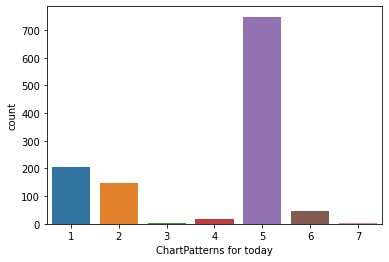

In [233]:
data['ChartPatterns-0'] = data['ChartPatterns-0'].astype(int)
ax = sns.countplot(x='ChartPatterns-0', data=data).set_xlabel('ChartPatterns for today')


Since most of the samples are of type 5, it means that the conditions by which I am  scanning the tickers selects more bullish patterns. **Lets see if they result in some immediate gains as well?** The figure suggests that with 80% chance we will make more than 10% gain in 4 days with no optimiziation or training, just by the rues by which I filter out the market !

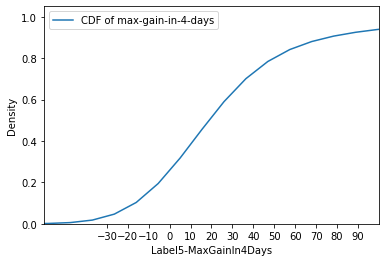

In [234]:
#plt.subplots()
#sns.ecdfplot(data[target_keys[0]])

plt.subplots()
#sns.kdeplot(data[target_keys[0]])  $ for PDF
sns.kdeplot(data[target_keys[0]], cumulative=True)   # for CDF plot
plt.xlim([-60,100])
plt.xticks(range(-30,100,10))
plt.legend(loc='upper left', labels=['CDF of max-gain-in-4-days'])


<AxesSubplot:xlabel='marketCap', ylabel='Density'>

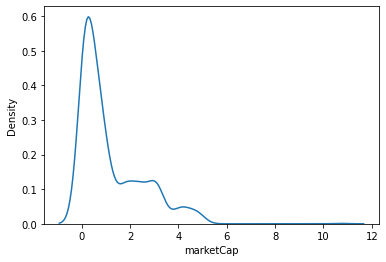

In [235]:
sns.kdeplot(data['marketCap'])

In [236]:
crr = data[list(data.keys())].corr()
Thr = 0.9
key_list = target_keys + Feature_keys

            
print(key_list)


['Label5-MaxGainIn4Days', 'VolumeNormalized-0', 'marketCap', 'EoDtoHoD-0', 'OverNighCahange-0', 'averageVolume', 'ChartPatterns-0', 'ChartPatterns-1', 'ChartPatterns-2', 'ChartPatterns-3', 'DayChange-0', 'DayChange-1', 'IntraDayVolumeIndicator-0', 'IntraDayVolumeIndicator-1', 'OverDayVolumeIndicator-0', 'OverDayVolumeIndicator-1']


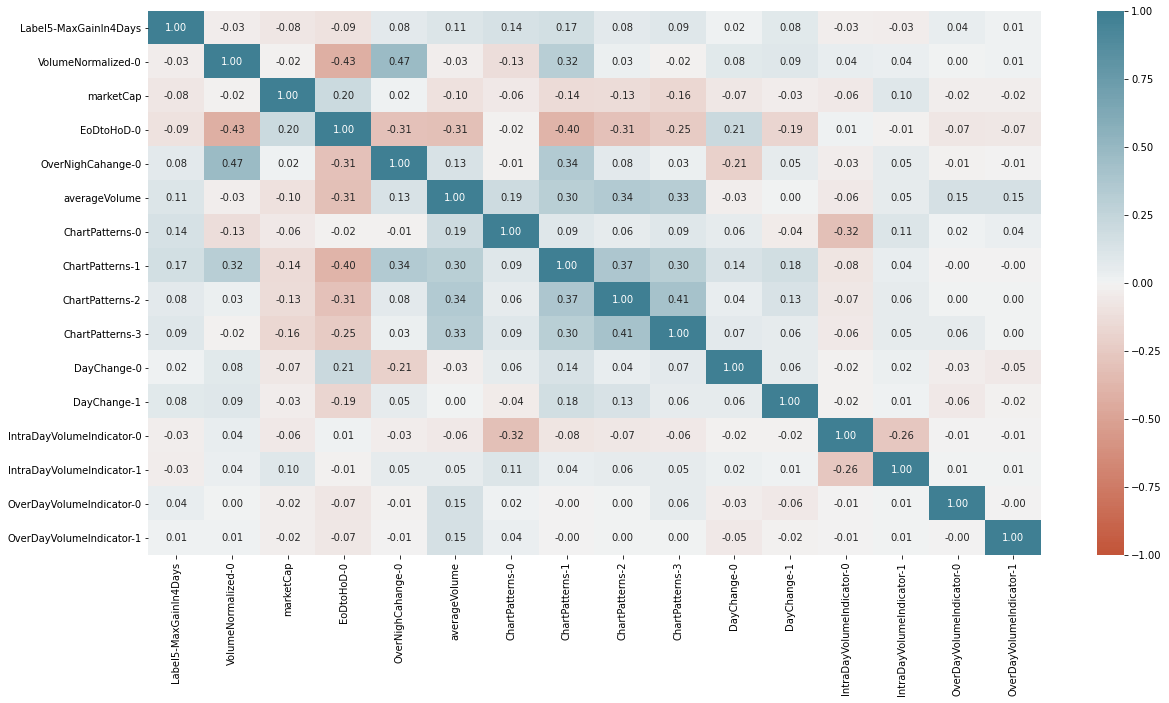

In [237]:
plt.subplots(figsize=(20,10))
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 

crr=data[key_list].corr()

g = sns.heatmap(crr,
                vmin=-1, vmax=1, center=0,
                annot=True, fmt = ".2f",
                cmap = sns.diverging_palette(20, 220, n=200))


Now we see some pretty good patterns and correlations. For example, `ChartPatterns-0` and `ChartPatterns-1`, `VolumeIndicators` have a good correlation. `averageVolume` seems to have a good correlation, but I cannot really trust it yet, since its value it not correct due to the problems we have mentioned with Yahoo Finance API. Once we are happy with the models (to be learned), we can test it for a week or so using live data and paper-trading. The gain is also confirmed by categorical outputs, suitable for learning simple classification models like decision tree. 

## Change target to category

We can change the target type to category and we choose the following bins:

1) larger than 25

1) between 10 to 25 

2) positive and less than 10

3) negative and larger than -7

4) less than -20


C:\ProgramData\Anaconda3\envs\stock\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


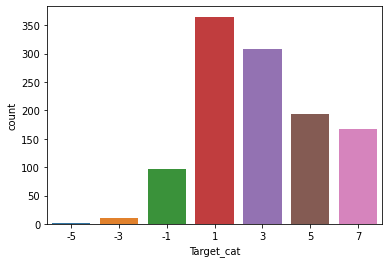

In [238]:
cut_labels_4 = [-5, -3, -1, 1, 3, 5, 7]
cut_bins = [-1000,-20, -7, 0, 10, 25, 50, 1000]
data['Target_cat'] = pd.cut(data[target_keys[0]], bins=cut_bins, labels=cut_labels_4)
g=sns.countplot(data.Target_cat)

# Decision tree

In [239]:
# Split dataset into training set and test set
data_copy = data[Feature_keys + ['Target_cat']]

# Handle Non values
data_copy = data_copy.dropna(how='any')  

X = data_copy[Feature_keys]
y = data_copy[['Target_cat']]

ToNormalize_keys = ['averageVolume','OverDayVolumeIndicator-0', 'OverDayVolumeIndicator-1']

#Normalize columns
#X[ToNormalize_keys]=(X[ToNormalize_keys]-X[ToNormalize_keys].mean())/X.std()
X[ToNormalize_keys] = X[ToNormalize_keys]/1000 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
X.head()





C:\ProgramData\Anaconda3\envs\stock\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,VolumeNormalized-0,marketCap,EoDtoHoD-0,OverNighCahange-0,averageVolume,ChartPatterns-0,ChartPatterns-1,ChartPatterns-2,ChartPatterns-3,DayChange-0,DayChange-1,IntraDayVolumeIndicator-0,IntraDayVolumeIndicator-1,OverDayVolumeIndicator-0,OverDayVolumeIndicator-1
0,0.820972,2.616123,-5.042022,-0.847457,1236.095,1,1.0,1.0,1.0,-3.418800,3.508769,1.0,1.0,0.001192,0.001247
1,1.097650,2.616123,-3.076920,-1.526716,1236.095,1,1.0,1.0,1.0,-2.325579,0.769230,1.0,1.0,0.001354,0.000557
2,0.625575,2.686552,-0.728149,0.248133,1739.840,5,1.0,1.0,1.0,1.237628,-2.184458,0.0,1.0,0.000883,0.000694
3,3.506874,2.686552,-3.382661,6.356962,1739.840,5,5.0,1.0,1.0,5.057478,1.237628,0.0,1.0,0.005606,0.000883
4,0.874103,2.686552,-4.329898,0.643781,1739.840,5,1.0,1.0,1.0,-1.066102,-4.115232,0.0,1.0,0.001340,0.000783


In [240]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

Result = pd.DataFrame({'True_label':list(y_test['Target_cat']),
                       'Prediction':y_pred})



In [241]:
th=5
Correct_Bull = Result[['True_label','Prediction']][(Result['True_label']>=th) & (Result['Prediction']>=th)]
False_Bull = Result[['True_label','Prediction']][(Result['True_label']<th) & (Result['Prediction']>=th)]
Correct_Bear = Result[['True_label','Prediction']][(Result['True_label']<th) & (Result['Prediction']<th)]
False_Bear = Result[['True_label','Prediction']][(Result['True_label']>=th) & (Result['Prediction']<th)]

print('TP/FP: ',len(Correct_Bull)/len(False_Bull))
print('Acc (TP+TN)/(P+N):',(len(Correct_Bull) + len(Correct_Bull))/(len(Result)))
print('Sensitivity TPR TP/P:',len(Correct_Bull)/(len(Correct_Bull) + len(False_Bear)))

TP/FP:  0.6666666666666666
Acc (TP+TN)/(P+N): 0.26900584795321636
Sensitivity TPR TP/P: 0.4742268041237113


# Conclusion

In [218]:
X = data[Feature_keys+['ticker']]

# Handle Non values
X = X.dropna(how='any')  

#Normalize columns
#X[Feature_keys] = (X[Feature_keys]-X[Feature_keys].mean())/X[Feature_keys].std()
X[ToNormalize_keys] = X[ToNormalize_keys]/1000

pred = clf.predict(X[Feature_keys])

Selected_Tickers = list(set(X['ticker'][(pred >=5 )]))
print(Selected_Tickers)

['HOFV', 'SBFM', 'ARPO', 'IPSI', 'GRLB', 'AAU', 'NBRV', 'POLA', 'NAK', 'SNDD', 'MTNB', 'BDR', 'IQST', 'RSSV', 'PLRTF', 'JAN', 'MBIO', 'CHS', 'CHUC', 'TRNX', 'SOS', 'KERN', 'IGC', 'SGMD', 'KALA', 'INPX', 'AIHS', 'UUU', 'CFMS', 'WDLF', 'GRNQ', 'MAXD', 'TAUG', 'GMER', 'GPORQ', 'AMTX', 'GRST', 'ASTI', 'AMIH', 'NES', 'ALRN', 'ATDS', 'PMCB', 'GNPX', 'ADMA', 'DECN', 'IZEA', 'DS', 'SMME', 'AITX', 'NSPR', 'TOPS', 'RSCF', 'NTN', 'VISM', 'TTOO', 'NAKD', 'SPI', 'TANH', 'GTLL', 'BTU', 'ZSAN', 'CBNT', 'EYES', 'MBRX', 'HCMC', 'DTEA', 'SNCA', 'AMMJ', 'ID', 'PHUN', 'NMTR', 'LVVV', 'EHVVF', 'ARTL', 'POTN', 'ALNA', 'CCRC', 'AMPE', 'SING', 'SLGG', 'SFOR', 'ATNF', 'IVFH', 'IGPK', 'SYN', 'IPV', 'BRQS', 'DFFN', 'LUVU', 'KOPN', 'PCTL', 'GDSI', 'BORR', 'DGLY', 'BTCS', 'WARM', 'POAI', 'ENG', 'PMPG', 'REI', 'TMBR', 'IMMR', 'CBBT', 'ASDN', 'POWW', 'LMFA', 'CLRB', 'HEPA', 'TRCH', 'AESE', 'MARK', 'BCDA', 'NXTD', 'TKOI', 'NVIV', 'STAF', 'SPLP', 'VALPQ', 'AXXA', 'VNUE', 'SQFT']


## Check tickers

In [219]:
%%capture
start = dt.datetime.today() - dt.timedelta(30)

end = dt.datetime.today()

cl_Price = pd.DataFrame()

for ticker in Selected_Tickers:
    cl_Price[ticker] = yf.download(ticker, start, end)['Adj Close']


Text(0.5, 1.0, 'ARPO')

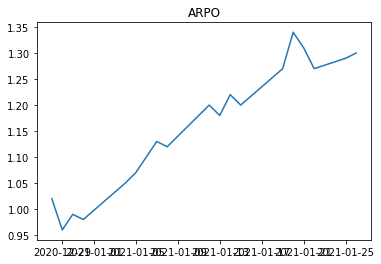

In [220]:
i=2
plt.plot(cl_Price[Selected_Tickers[i]])    
plt.title(Selected_Tickers[i])

# Check new tickers


In [247]:
X_ = pd.read_json('./Data/Test/EoD-dataset2021-01-27905734.json')


print(X_.ticker)
asda
tkrs = X_.ticker

X_ = X_[Feature_keys+['ticker']]

# Handle Non values
X_ = X_.dropna(how='any')  

#Normalize columns
X_[ToNormalize_keys] = X_[ToNormalize_keys]/1000
#X_[Feature_keys] = (X_[Feature_keys]-X_[Feature_keys].mean())/X_[Feature_keys].std()

pred_ = clf.predict(X_[Feature_keys])
new_res = pd.DataFrame({'Ticker':tkrs,
                       'Prediction':pred_})
print(new_res)

Series([], Name: ticker, dtype: float64)


NameError: name 'asda' is not defined